In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.model_selection import train_test_split
plt.rcParams['figure.figsize'] = [80, 25]

# After importing the modules, we are defining our functions:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# ADVISE: Don't run LSTM code. Only do it if you have time to spare.
It takes around than 1 hour to run all the models, so only run it if time is not a problem.

## LSTM with more than one layer

First we read the data:

In [2]:
df = pd.read_csv('./final_dataframe.csv',index_col='datetime')

Then we define the function for splitting the data:

In [3]:
def split_data(df, m, n):
    """
    With this function we are splitting the data in arrays of lenght m to predict n values.
    """
    range_values = df.shape[0]-m-n+1
    X_aux = []
    y_aux = []
    for i in range(range_values):
        X_aux.append(np.array(df.iloc[i:i+m,]))
        y_aux.append(np.array(df.iloc[i+m:i+m+n,]))
    
    X = np.array(X_aux)
    y = np.array(y_aux)
    
    return X, y

Splitting the data:

In [4]:
# We are selecting the columns that we want:
df2 = df[['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']]

# Let's reduce the number of days because of limitations:
days= 7

# We fit the scalers:
scaler = MinMaxScaler(feature_range=(0, 1))
aux = scaler.fit_transform(df2)
df3 = pd.DataFrame(aux, columns = df2.columns, index=df2.index)
last_value = df3.shape[0]-24*days

# Then we split into X and y:
m = days * 24
n = days * 24
X , y = split_data(df3, m, n)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8,test_size=0.2, random_state=101)

# Last days to check:
X_test_pd = df3[last_value-m:last_value].values
X_test_pd = X_test_pd.reshape(X_test_pd.shape[1],X_test_pd.shape[0],1)
y_test_pd = df3[last_value:].values

Now, we create the model:

Epoch 1/20
449/449 - 163s - loss: 0.0468 - val_loss: 0.0333
Epoch 2/20
449/449 - 159s - loss: 0.0157 - val_loss: 0.0076
Epoch 3/20
449/449 - 164s - loss: 0.0089 - val_loss: 0.0063
Epoch 4/20
449/449 - 161s - loss: 0.0073 - val_loss: 0.0051
Epoch 5/20
449/449 - 166s - loss: 0.0062 - val_loss: 0.0043
Epoch 6/20
449/449 - 155s - loss: 0.0057 - val_loss: 0.0041
Epoch 7/20
449/449 - 157s - loss: 0.0053 - val_loss: 0.0039
Epoch 8/20
449/449 - 151s - loss: 0.0050 - val_loss: 0.0036
Epoch 9/20
449/449 - 152s - loss: 0.0048 - val_loss: 0.0035
Epoch 10/20
449/449 - 152s - loss: 0.0047 - val_loss: 0.0033
Epoch 11/20
449/449 - 159s - loss: 0.0046 - val_loss: 0.0033
Epoch 12/20
449/449 - 162s - loss: 0.0044 - val_loss: 0.0031
Epoch 13/20
449/449 - 150s - loss: 0.0044 - val_loss: 0.0032
Epoch 14/20
449/449 - 145s - loss: 0.0043 - val_loss: 0.0030
Epoch 15/20
449/449 - 148s - loss: 0.0042 - val_loss: 0.0030
Epoch 16/20
449/449 - 147s - loss: 0.0042 - val_loss: 0.0029
Epoch 17/20
449/449 - 153s - loss

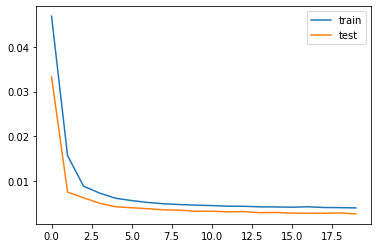

CPU times: user 3h 8min 9s, sys: 35min 14s, total: 3h 43min 24s
Wall time: 51min 54s


In [5]:
%%time
# design network
model_mult_lstm = Sequential()

model_mult_lstm.add(LSTM(units = 100, input_shape = (X_train.shape[1], X_train.shape[2]), return_sequences = True))
model_mult_lstm.add(Dropout(0.1))

model_mult_lstm.add(LSTM(units = 50, return_sequences = True))
model_mult_lstm.add(Dropout(0.1))

model_mult_lstm.add(LSTM(units = 20, return_sequences = False))
model_mult_lstm.add(Dropout(0.1))

model_mult_lstm.add(Dense(units = n, activation = 'relu'))

model_mult_lstm.compile(optimizer = 'adam', loss = 'mse')

history = model_mult_lstm.fit(X_train, y_train, epochs = 20, batch_size = 100, validation_data=(X_test,y_test) , verbose=2, shuffle=True)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Finally we check the results:

Para los resultados de los últimos 7 días se obtiene un RMSE de  10.09269087976934 , un R2 de  0.9161526647016454  y un MAPE de 11.508015260921695


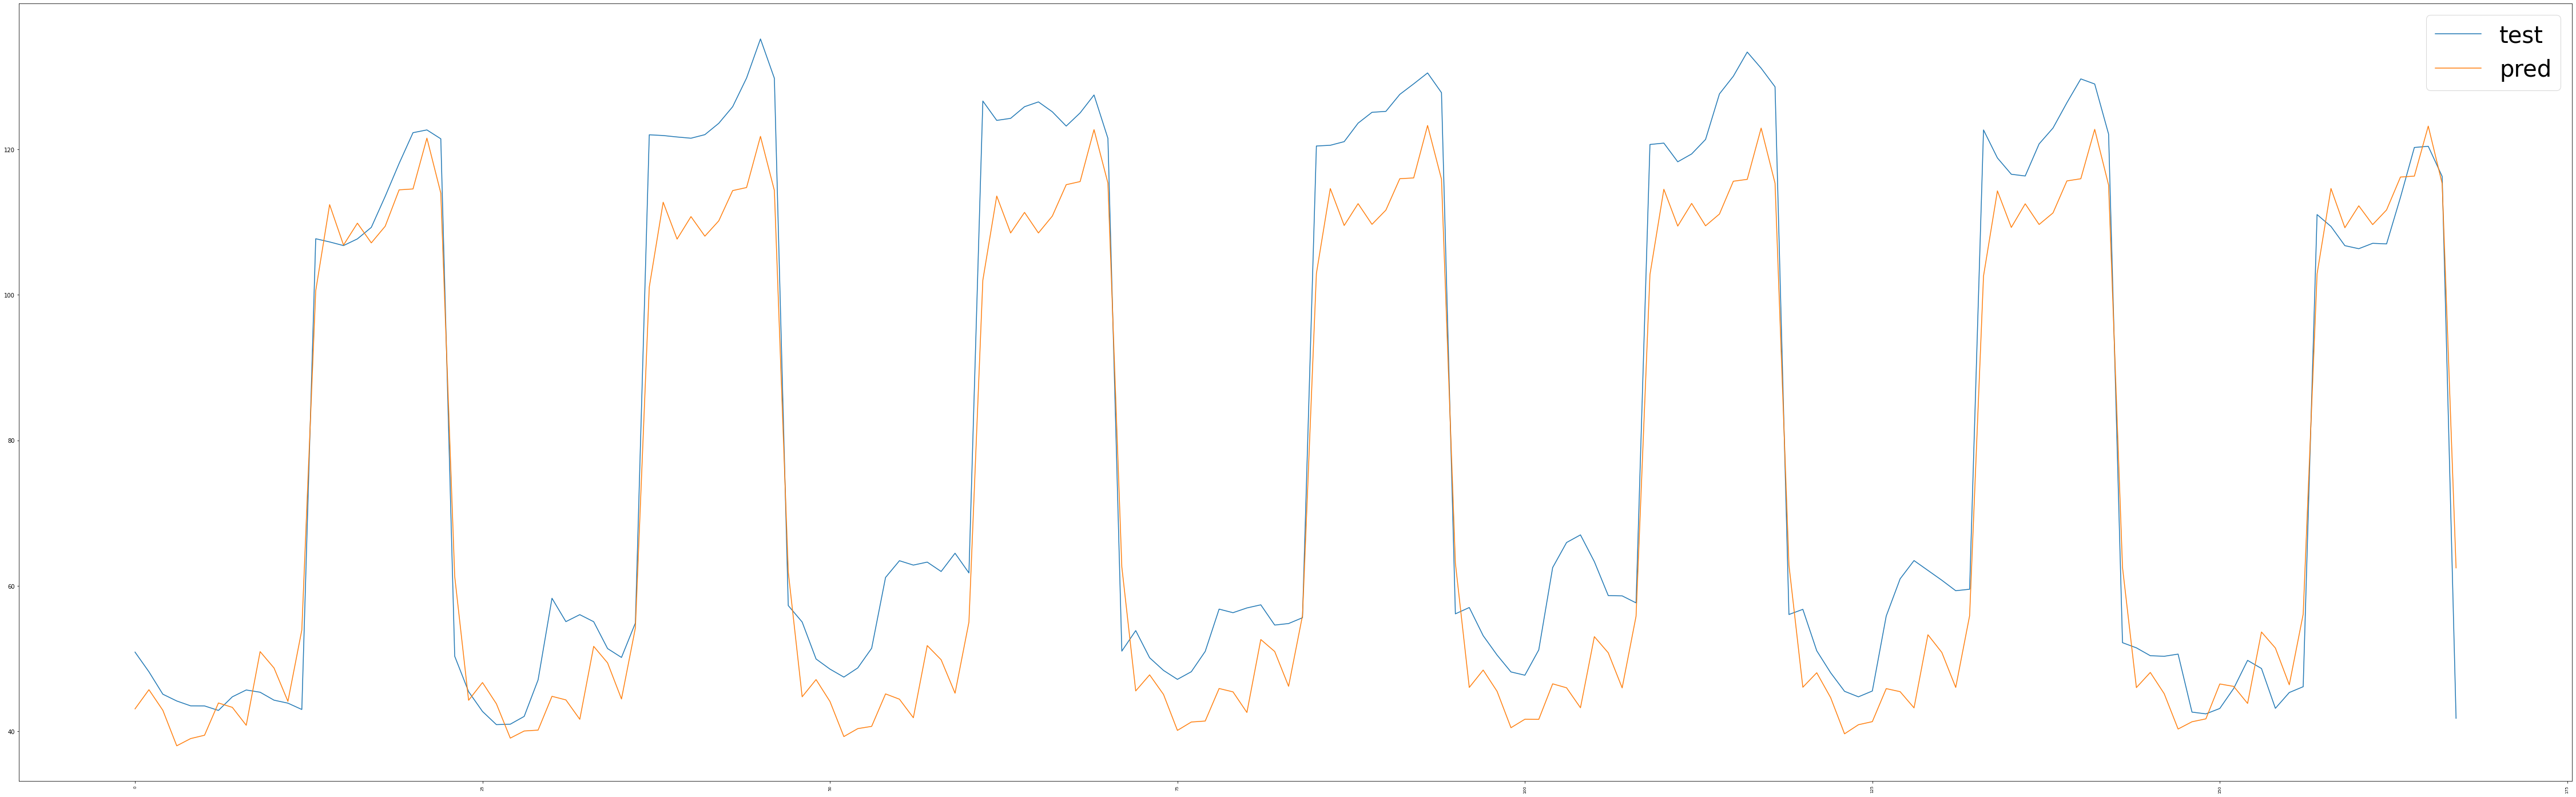

In [6]:
# make a prediction
yhat = model_mult_lstm.predict(X_test_pd)
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(y_test_pd)
# calculate metrics
inv_y = inv_y.reshape(1,168)[0]
inv_yhat = inv_yhat[0]
print('Para los resultados de los últimos 7 días se obtiene un RMSE de ',np.sqrt(mean_squared_error(inv_y, inv_yhat)),', un R2 de ',r2_score(inv_y, inv_yhat),' y un MAPE de',mean_absolute_percentage_error(inv_y, inv_yhat))
# Finally we plot the results:
plt.rcParams['figure.figsize'] = [80, 25]
plt.plot(np.array(inv_y), label='test')
plt.plot(np.array(inv_yhat), label='pred')
plt.legend(prop={'size': 40})
plt.xticks(rotation=90, fontsize = 7)
plt.show()

Finally, we export the results

In [7]:
pd.DataFrame({'test':inv_y, 'prediccion':inv_yhat},index = df3[last_value:].index).to_csv('./../Visualization/Neural_network_LSTM_multilayer.csv')

## DNN with shuffled data

First, we read the data:

In [8]:
df = pd.read_csv('./final_dataframe.csv',index_col='datetime')

In [9]:
days = 28

It is important to considerate the time that we want to predict. If we want to know the price for 1 week, we will need to shift the target column X days so, with the information we have today, we can predict the value for the electricity in X days:

In [10]:
df['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']=df['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)'].shift(-24*days)
df.dropna(axis=0,how='any',inplace=True)

Then we select the columns:

In [11]:
model_columns = ['Demanda_programada_P48_total', 
                 'Demanda_programada_P48_Correccion_eolica',
                 'Demanda_programada_P48_Correccion_solar',
                 'Precio_mercado_SPOT_Diario',
                 'Precio_mercado_SPOT_Intradiario_Sesion_1',
                 'Precio_mercado_SPOT_Intradiario_Sesion_2',
                 'Precio_mercado_SPOT_Intradiario_Sesion_3',
                 'Precio_mercado_SPOT_Intradiario_Sesion_4',
                 'Precio_mercado_SPOT_Intradiario_Sesion_5',
                 'Precio_mercado_SPOT_Intradiario_Sesion_6',
                 'Precio_mercado_SPOT_Intradiario_Sesion_7',
                 'Generacion_programada_P48_Biogas',
                 'Generacion_programada_P48_Biomasa',
                 'Generacion_programada_P48_Ciclo_combinado',
                 'Generacion_programada_P48_Consumo_bombeo',
                 'Generacion_programada_P48_Derivados_del_petroleo_o_carbon',
                 'Generacion_programada_P48_Energia_residual',
                 'Generacion_programada_P48_Enlace_Baleares',
                 'Generacion_programada_P48_Eolica_terrestre',
                 'Generacion_programada_P48_Gas_Natural',
                 'Generacion_programada_P48_Gas_Natural_Cogeneracion',
                 'Generacion_programada_P48_Hidraulica_UGH',
                 'Generacion_programada_P48_Hidraulica_no_UGH',
                 'Generacion_programada_P48_Hulla_antracita',
                 'Generacion_programada_P48_Hulla_sub-bituminosa',
                 'Generacion_programada_P48_Nuclear',
                 'Generacion_programada_P48_Oceano_y_geotermica',
                 'Generacion_programada_P48_Residuos_domesticos_y_similares',
                 'Generacion_programada_P48_Residuos_varios',
                 'Generacion_programada_P48_Solar_fotovoltaica',
                 'Generacion_programada_P48_Solar_termica',
                 'Generacion_programada_P48_Subproductos_mineria',
                 'Generacion_programada_P48_Turbinacion_bombeo',
                 'Consumer_price_index', 
                 'Time_required_to_get_electricity_(days)',
                 'Inflation,consumer_prices_(annual_%)',
                 'Employment_in_industry_(%_of_total_employment)', 
                 'PIB_Trimestral', 
                 'Var_Trim_PIB_(%)', 
                 'Var_anual_PIB_Trim_(%)',
                 'IBEX35',
                 'Red_Electrica',
                 'Temperature',
                 #'Weekday_Monday','Weekday_Tuesday', 'Weekday_Wednesday','Weekday_Thursday',
                 #'Weekday_Friday', 'Weekday_Saturday', 
                 'sin_weekday','cos_weekday',
                 'holidays', 
                 #'Hour_0', 'Hour_1', 'Hour_2',
                 #'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9',
                 #'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15',
                 #'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21',
                 #'Hour_22',
                 'sin_hour','cos_hour','sin_month','cos_month',
                 #'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
                 #'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
                 'Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6', 'Day_7', 'Day_8',
                 'Day_9', 'Day_10', 'Day_11', 'Day_12', 'Day_13', 'Day_14', 'Day_15',
                 'Day_16', 'Day_17', 'Day_18', 'Day_19', 'Day_20', 'Day_21', 'Day_22',
                 'Day_23', 'Day_24', 'Day_25', 'Day_26', 'Day_27', 'Day_28', 'Day_29',
                 'Day_30']

After that we have to split the data into train and test:

In [12]:
# We are selecting the columns that we want:
df2 = df[['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']+model_columns]

# We fit the scalers:
scaler = MinMaxScaler(feature_range=(0, 1))
aux = scaler.fit_transform(df2)
df3 = pd.DataFrame(aux, columns = df2.columns, index=df2.index)
last_value = df3.shape[0]-24*days


# Then we split into X and y:
X = df3.loc[:,model_columns]
y = df3.loc[:,'Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']

X_train_aux, X_test_aux, y_train_aux, y_test_aux = train_test_split(X[:last_value], y[:last_value], train_size=0.8,test_size=0.2, random_state=101)

# Convert everything to float32:
X_train = X_train_aux.values.astype('float32')
y_train = y_train_aux.values.astype('float32')
X_test = X_test_aux.values.astype('float32')
y_test = y_test_aux.values.astype('float32')

# Let's get the last X days:
X_test_pd = X[last_value:].values.astype('float32')
y_test_pd = y[last_value:].values.astype('float32')

We build the model:

Epoch 1/30
441/441 - 58s - loss: 0.0078 - val_loss: 0.0040
Epoch 2/30
441/441 - 58s - loss: 0.0029 - val_loss: 0.0017
Epoch 3/30
441/441 - 58s - loss: 0.0019 - val_loss: 0.0020
Epoch 4/30
441/441 - 121s - loss: 0.0017 - val_loss: 0.0012
Epoch 5/30
441/441 - 124s - loss: 0.0012 - val_loss: 0.0010
Epoch 6/30
441/441 - 64s - loss: 0.0015 - val_loss: 0.0022
Epoch 7/30
441/441 - 63s - loss: 0.0015 - val_loss: 0.0011
Epoch 8/30
441/441 - 63s - loss: 0.0013 - val_loss: 0.0044
Epoch 9/30
441/441 - 63s - loss: 0.0010 - val_loss: 7.4439e-04
Epoch 10/30
441/441 - 66s - loss: 6.4174e-04 - val_loss: 6.6275e-04
Epoch 11/30
441/441 - 64s - loss: 5.8216e-04 - val_loss: 8.1341e-04
Epoch 12/30
441/441 - 62s - loss: 5.4043e-04 - val_loss: 5.7325e-04
Epoch 13/30
441/441 - 61s - loss: 5.0597e-04 - val_loss: 5.8904e-04
Epoch 14/30
441/441 - 143s - loss: 6.6027e-04 - val_loss: 0.0029
Epoch 15/30
441/441 - 173s - loss: 0.0015 - val_loss: 6.3019e-04
Epoch 16/30
441/441 - 67s - loss: 4.5289e-04 - val_loss: 5.40

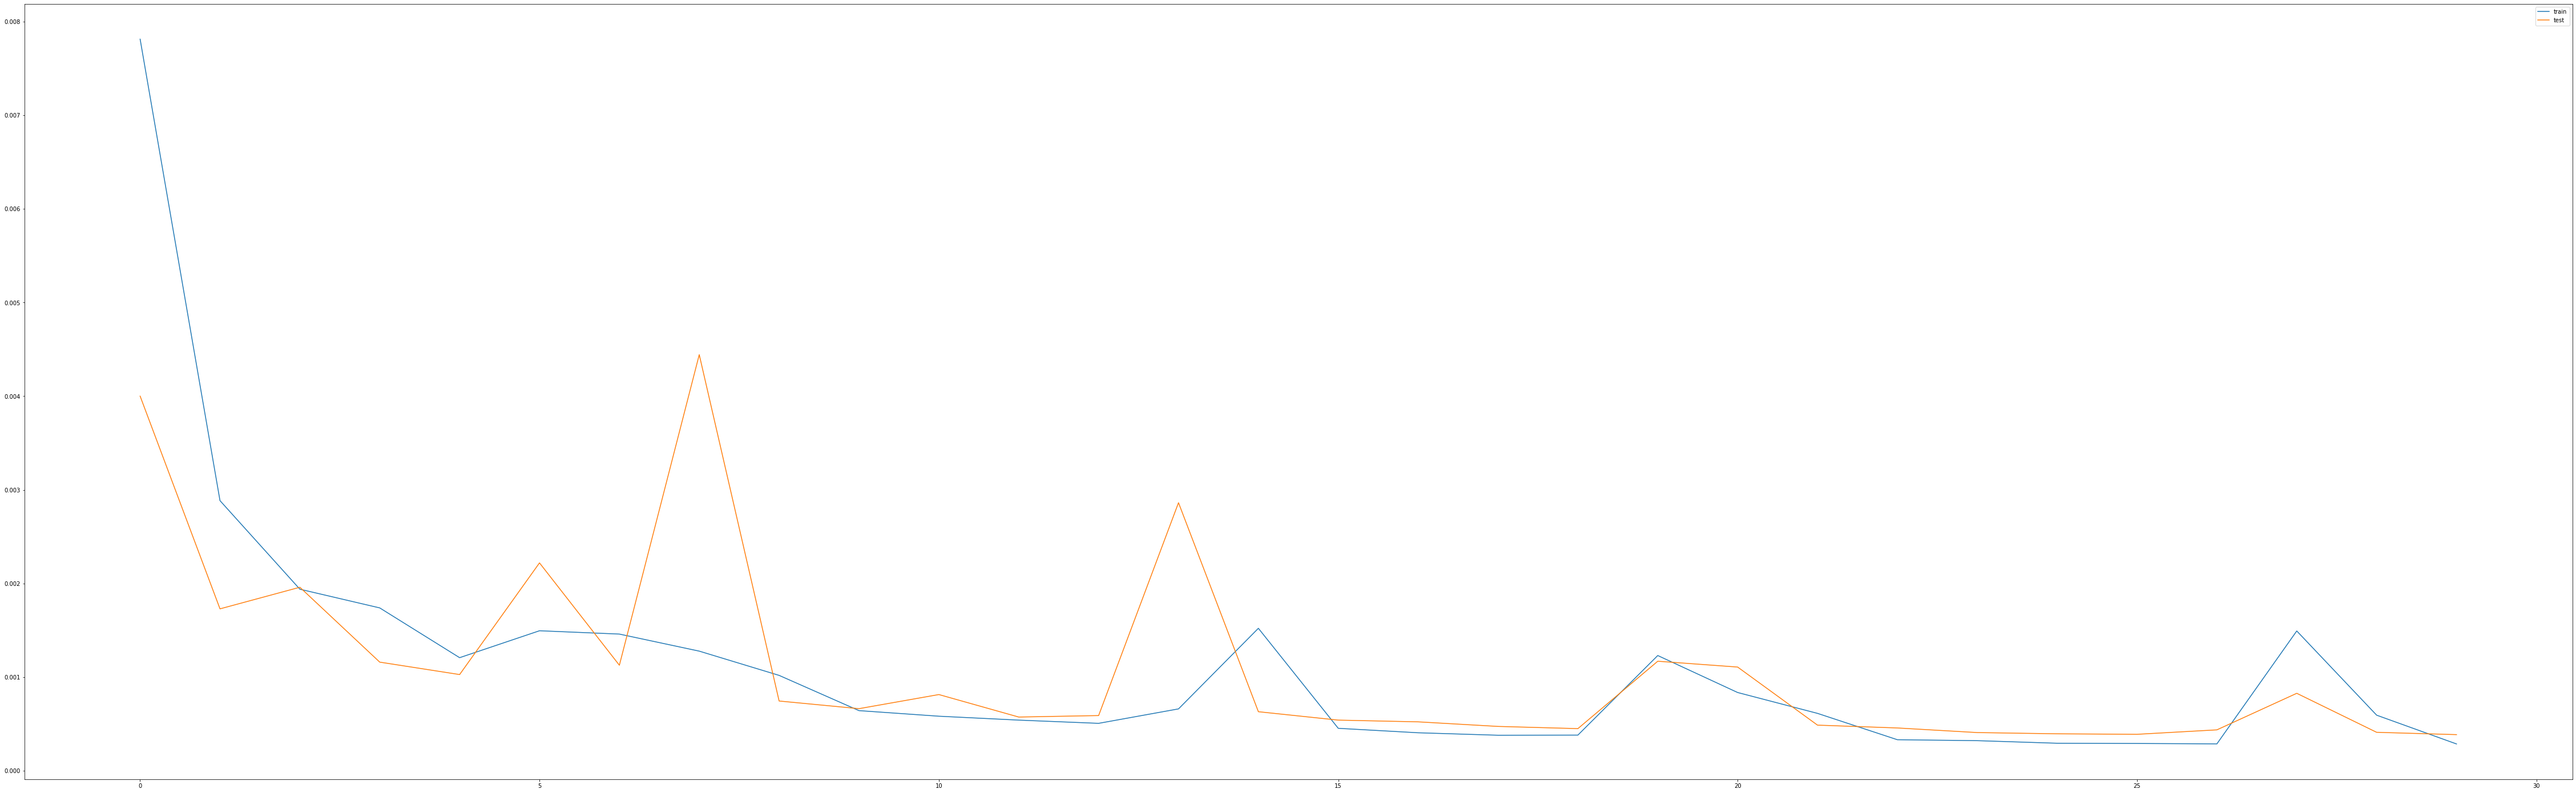

CPU times: user 1h 46min 10s, sys: 29min 16s, total: 2h 15min 27s
Wall time: 35min 23s


In [13]:
%%time
# design network
model_dnn_shuf = Sequential()
model_dnn_shuf.add(Dense(4096, input_dim=X_train.shape[1], activation='relu'))
#model_dnn_shuf.add(Dropout(0.1))
model_dnn_shuf.add(Dense(2048, activation='relu'))
#model_dnn_shuf.add(Dropout(0.1))
model_dnn_shuf.add(Dense(1024, activation='relu'))
#model_dnn_shuf.add(Dropout(0.1))
model_dnn_shuf.add(Dense(512, activation='relu'))
#model_dnn_shuf.add(Dropout(0.1))
model_dnn_shuf.add(Dense(256, activation='relu'))
#model_dnn_shuf.add(Dropout(0.1))
model_dnn_shuf.add(Dense(128, activation='relu'))
#model_dnn_shuf.add(Dropout(0.1))
model_dnn_shuf.add(Dense(64, activation='relu'))
#model_dnn_shuf.add(Dropout(0.1))
model_dnn_shuf.add(Dense(32, activation='relu'))
#model_dnn_shuf.add(Dropout(0.1))
model_dnn_shuf.add(Dense(16, activation='relu'))
#model_dnn_shuf.add(Dropout(0.1))
model_dnn_shuf.add(Dense(1))
model_dnn_shuf.compile(loss='mse', optimizer='adam')
# fit network
history = model_dnn_shuf.fit(X_train, y_train, epochs=30, batch_size=100, validation_data=(X_test, y_test), verbose=2, shuffle=True)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Finally we plot the results and the metrics:

Para los resultados de las últimas 4 semanas se obtiene un RMSE de  4.1498876 , un R2 de  0.9886301694302616  y un MAPE de 4.217768087983131


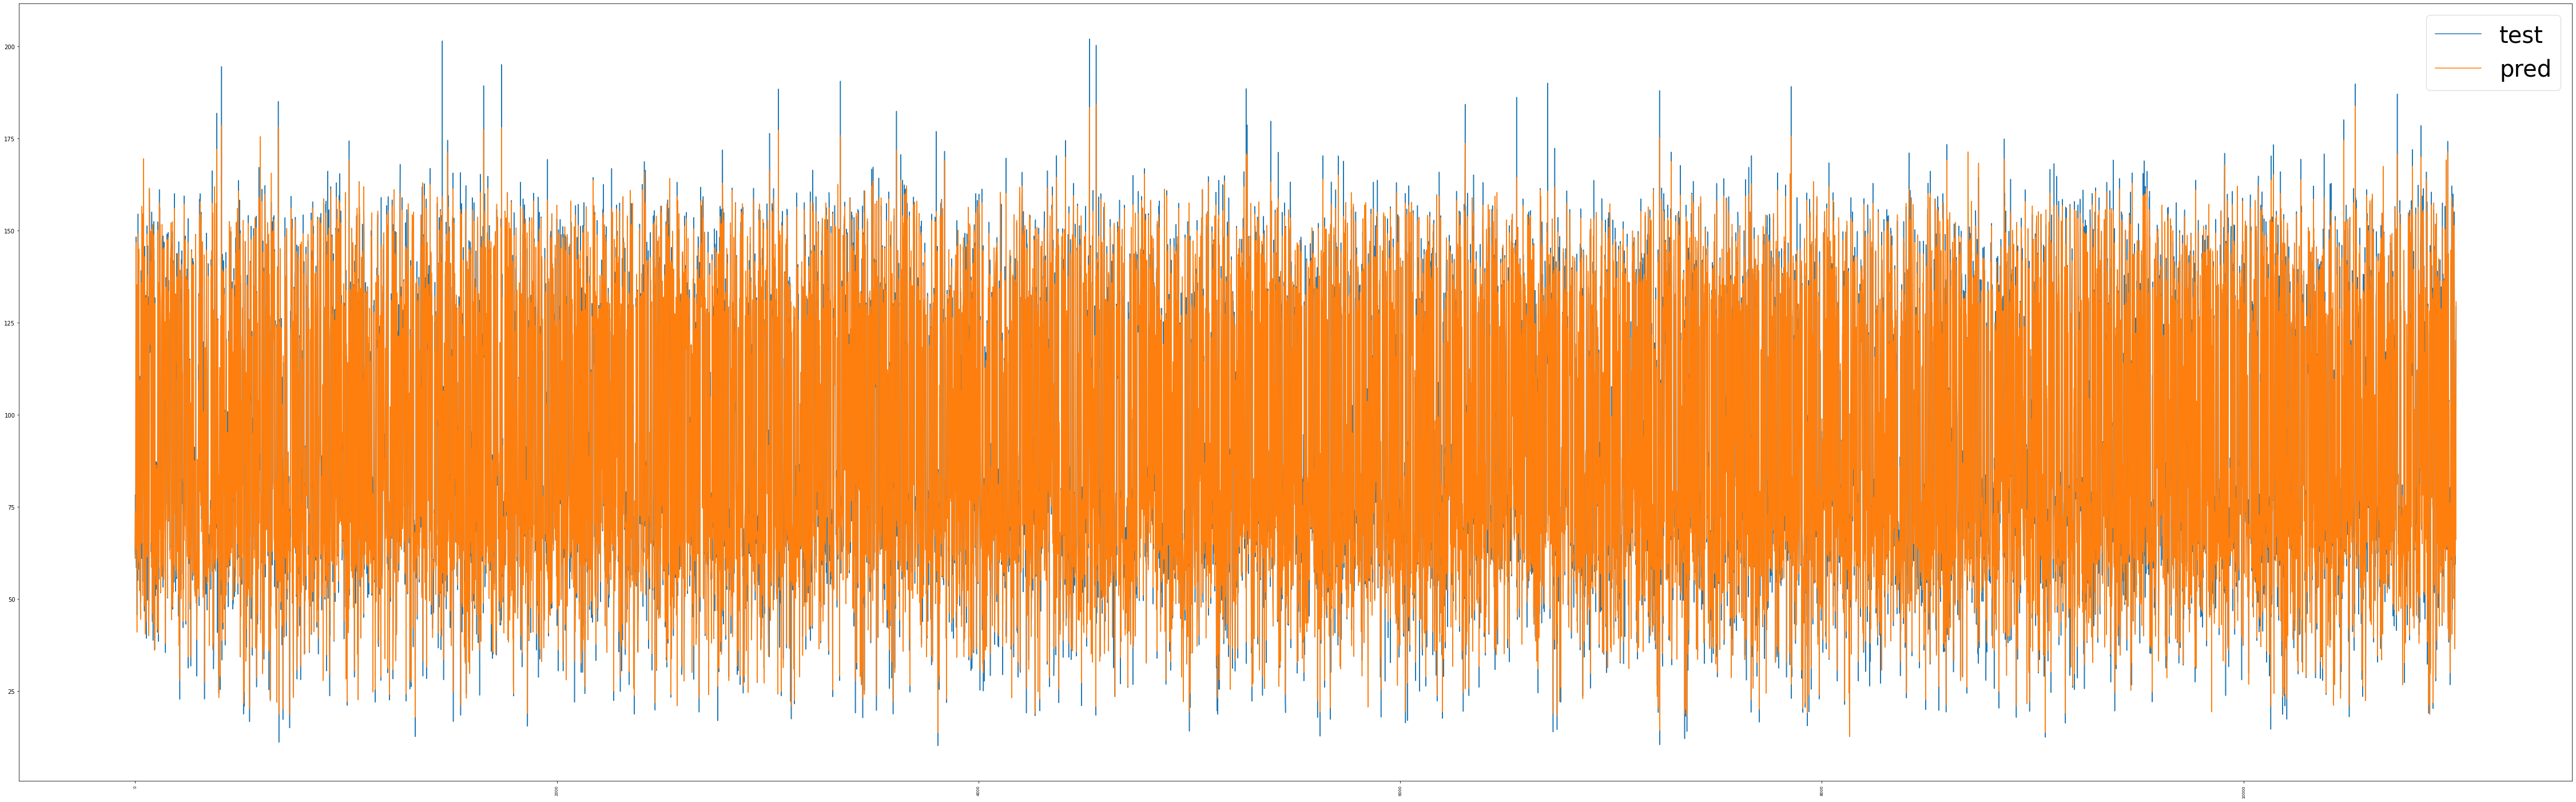

In [14]:
# make a prediction
yhat = model_dnn_shuf.predict(X_test)
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, X_test[:, :]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
inv_y = np.concatenate((y_test.reshape(-1,1), X_test[:, :]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate metrics and plot:
plt.rcParams['figure.figsize'] = [80, 25]
print('Para los resultados de las últimas 4 semanas se obtiene un RMSE de ',np.sqrt(mean_squared_error(inv_y, inv_yhat)),', un R2 de ',r2_score(inv_y, inv_yhat),' y un MAPE de',mean_absolute_percentage_error(inv_y, inv_yhat))
plt.plot(inv_y, label='test')
plt.plot(inv_yhat, label='pred')
plt.legend(prop={'size': 40})
plt.xticks(rotation=90, fontsize = 7)
plt.show()

Para los resultados de las últimas 4 semanas se obtiene un RMSE de  6.124169 , un R2 de  0.9681483084358267  y un MAPE de 7.427702844142914


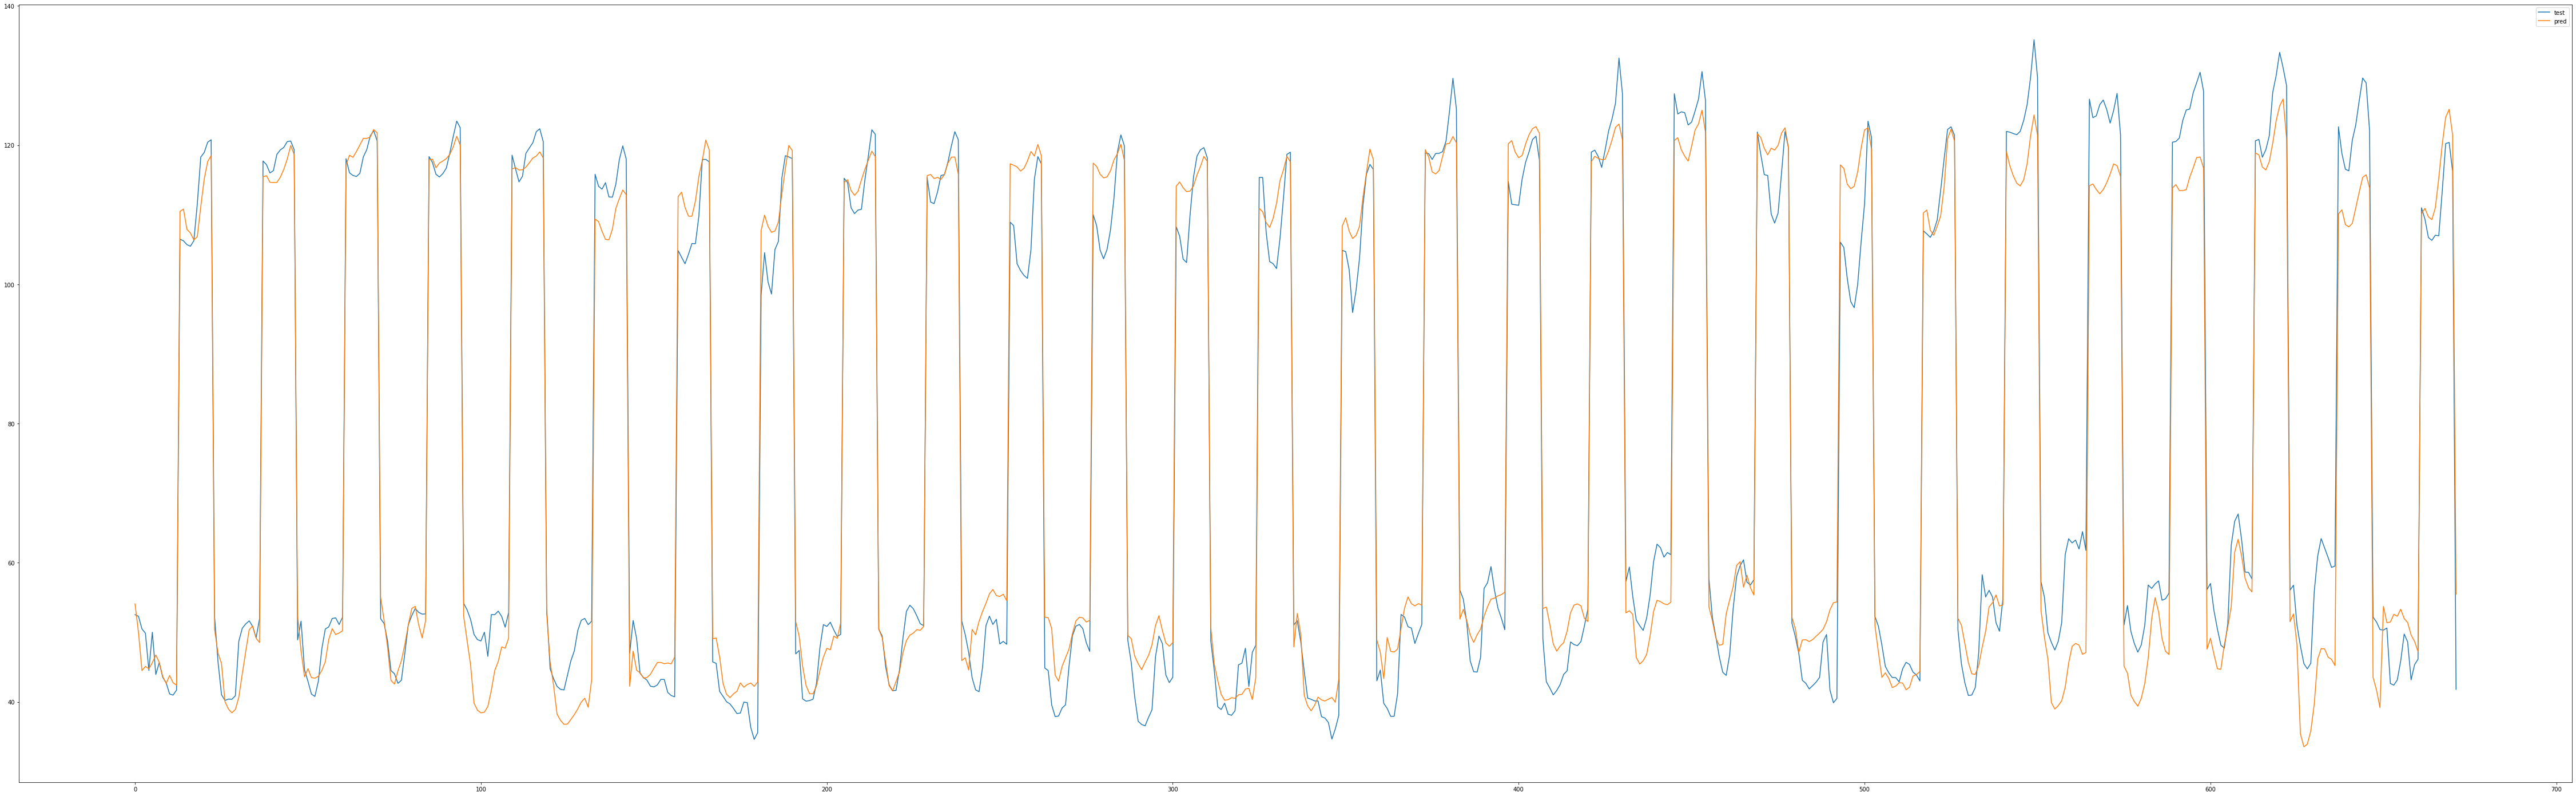

In [15]:
# make a prediction
yhat = model_dnn_shuf.predict(X_test_pd)
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, X_test_pd[:, :]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
inv_y = np.concatenate((y_test_pd.reshape(-1,1), X_test_pd[:, :]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate metrics and plot:
plt.rcParams['figure.figsize'] = [80, 25]
print('Para los resultados de las últimas 4 semanas se obtiene un RMSE de ',np.sqrt(mean_squared_error(inv_y, inv_yhat)),', un R2 de ',r2_score(inv_y, inv_yhat),' y un MAPE de',mean_absolute_percentage_error(inv_y, inv_yhat))
plt.plot(inv_y, label='test')
plt.plot(inv_yhat, label='pred')
plt.legend()
plt.show()

Exporting the results:

In [16]:
pd.DataFrame({'test':inv_y, 'prediccion':inv_yhat},index = y[last_value:].index).to_csv('./../Visualization/Neural_network_DNN_shuffled.csv')

## DNN with all data:

First, we read the data:

In [17]:
df = pd.read_csv('./final_dataframe.csv',index_col='datetime')

In [18]:
days = 28

It is important to considerate the time that we want to predict. If we want to know the price for 1 week, we will need to shift the target column X days so, with the information we have today, we can predict the value for the electricity in X days:

In [19]:
df['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']=df['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)'].shift(-24*days)
df.dropna(axis=0,how='any',inplace=True)

Then we select the columns:

In [20]:
model_columns = ['Demanda_programada_P48_total', 
                 'Demanda_programada_P48_Correccion_eolica',
                 'Demanda_programada_P48_Correccion_solar',
                 'Precio_mercado_SPOT_Diario',
                 'Precio_mercado_SPOT_Intradiario_Sesion_1',
                 'Precio_mercado_SPOT_Intradiario_Sesion_2',
                 'Precio_mercado_SPOT_Intradiario_Sesion_3',
                 'Precio_mercado_SPOT_Intradiario_Sesion_4',
                 'Precio_mercado_SPOT_Intradiario_Sesion_5',
                 'Precio_mercado_SPOT_Intradiario_Sesion_6',
                 'Precio_mercado_SPOT_Intradiario_Sesion_7',
                 'Generacion_programada_P48_Biogas',
                 'Generacion_programada_P48_Biomasa',
                 'Generacion_programada_P48_Ciclo_combinado',
                 'Generacion_programada_P48_Consumo_bombeo',
                 'Generacion_programada_P48_Derivados_del_petroleo_o_carbon',
                 'Generacion_programada_P48_Energia_residual',
                 'Generacion_programada_P48_Enlace_Baleares',
                 'Generacion_programada_P48_Eolica_terrestre',
                 'Generacion_programada_P48_Gas_Natural',
                 'Generacion_programada_P48_Gas_Natural_Cogeneracion',
                 'Generacion_programada_P48_Hidraulica_UGH',
                 'Generacion_programada_P48_Hidraulica_no_UGH',
                 'Generacion_programada_P48_Hulla_antracita',
                 'Generacion_programada_P48_Hulla_sub-bituminosa',
                 'Generacion_programada_P48_Nuclear',
                 'Generacion_programada_P48_Oceano_y_geotermica',
                 'Generacion_programada_P48_Residuos_domesticos_y_similares',
                 'Generacion_programada_P48_Residuos_varios',
                 'Generacion_programada_P48_Solar_fotovoltaica',
                 'Generacion_programada_P48_Solar_termica',
                 'Generacion_programada_P48_Subproductos_mineria',
                 'Generacion_programada_P48_Turbinacion_bombeo',
                 'Consumer_price_index', 
                 'Time_required_to_get_electricity_(days)',
                 'Inflation,consumer_prices_(annual_%)',
                 'Employment_in_industry_(%_of_total_employment)', 
                 'PIB_Trimestral', 
                 'Var_Trim_PIB_(%)', 
                 'Var_anual_PIB_Trim_(%)',
                 'IBEX35',
                 'Red_Electrica',
                 'Temperature',
                 #'Weekday_Monday','Weekday_Tuesday', 'Weekday_Wednesday','Weekday_Thursday',
                 #'Weekday_Friday', 'Weekday_Saturday', 
                 'sin_weekday','cos_weekday',
                 'holidays', 
                 #'Hour_0', 'Hour_1', 'Hour_2',
                 #'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9',
                 #'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15',
                 #'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21',
                 #'Hour_22',
                 'sin_hour','cos_hour','sin_month','cos_month',
                 #'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
                 #'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
                 'Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6', 'Day_7', 'Day_8',
                 'Day_9', 'Day_10', 'Day_11', 'Day_12', 'Day_13', 'Day_14', 'Day_15',
                 'Day_16', 'Day_17', 'Day_18', 'Day_19', 'Day_20', 'Day_21', 'Day_22',
                 'Day_23', 'Day_24', 'Day_25', 'Day_26', 'Day_27', 'Day_28', 'Day_29',
                 'Day_30']

After that we have to split the data into train and test:

In [21]:
# We are selecting the columns that we want:
df2 = df[['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']+model_columns]

# We fit the scalers:
scaler = MinMaxScaler(feature_range=(0, 1))
aux = scaler.fit_transform(df2)
df3 = pd.DataFrame(aux, columns = df2.columns, index=df2.index)
last_value = df3.shape[0]-24*days

# Then we split into X and y:
X = df3.loc[:,model_columns]
y = df3.loc[:,'Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']

# We separate into train and test:
y_train_aux = y.iloc[:last_value,]
X_train_aux = X.iloc[:last_value,]
y_test_aux = y.iloc[last_value:,]
X_test_aux = X.iloc[last_value:,]

# Pasamos a float todo:
X_train = X_train_aux.values.astype('float32')
y_train = y_train_aux.values.astype('float32')
X_test = X_test_aux.values.astype('float32')
y_test = y_test_aux.values.astype('float32')

We build the model:

Epoch 1/50
2/2 - 4s - loss: 0.1502 - val_loss: 0.3410
Epoch 2/50
2/2 - 4s - loss: 0.2034 - val_loss: 0.0439
Epoch 3/50
2/2 - 4s - loss: 0.0902 - val_loss: 0.0468
Epoch 4/50
2/2 - 4s - loss: 0.0860 - val_loss: 0.0246
Epoch 5/50
2/2 - 4s - loss: 0.0504 - val_loss: 0.0569
Epoch 6/50
2/2 - 4s - loss: 0.0527 - val_loss: 0.0266
Epoch 7/50
2/2 - 4s - loss: 0.0393 - val_loss: 0.0216
Epoch 8/50
2/2 - 4s - loss: 0.0439 - val_loss: 0.0191
Epoch 9/50
2/2 - 4s - loss: 0.0366 - val_loss: 0.0189
Epoch 10/50
2/2 - 4s - loss: 0.0325 - val_loss: 0.0202
Epoch 11/50
2/2 - 4s - loss: 0.0298 - val_loss: 0.0130
Epoch 12/50
2/2 - 4s - loss: 0.0266 - val_loss: 0.0134
Epoch 13/50
2/2 - 4s - loss: 0.0267 - val_loss: 0.0109
Epoch 14/50
2/2 - 4s - loss: 0.0236 - val_loss: 0.0119
Epoch 15/50
2/2 - 4s - loss: 0.0251 - val_loss: 0.0100
Epoch 16/50
2/2 - 3s - loss: 0.0226 - val_loss: 0.0111
Epoch 17/50
2/2 - 4s - loss: 0.0225 - val_loss: 0.0096
Epoch 18/50
2/2 - 4s - loss: 0.0209 - val_loss: 0.0100
Epoch 19/50
2/2 - 4

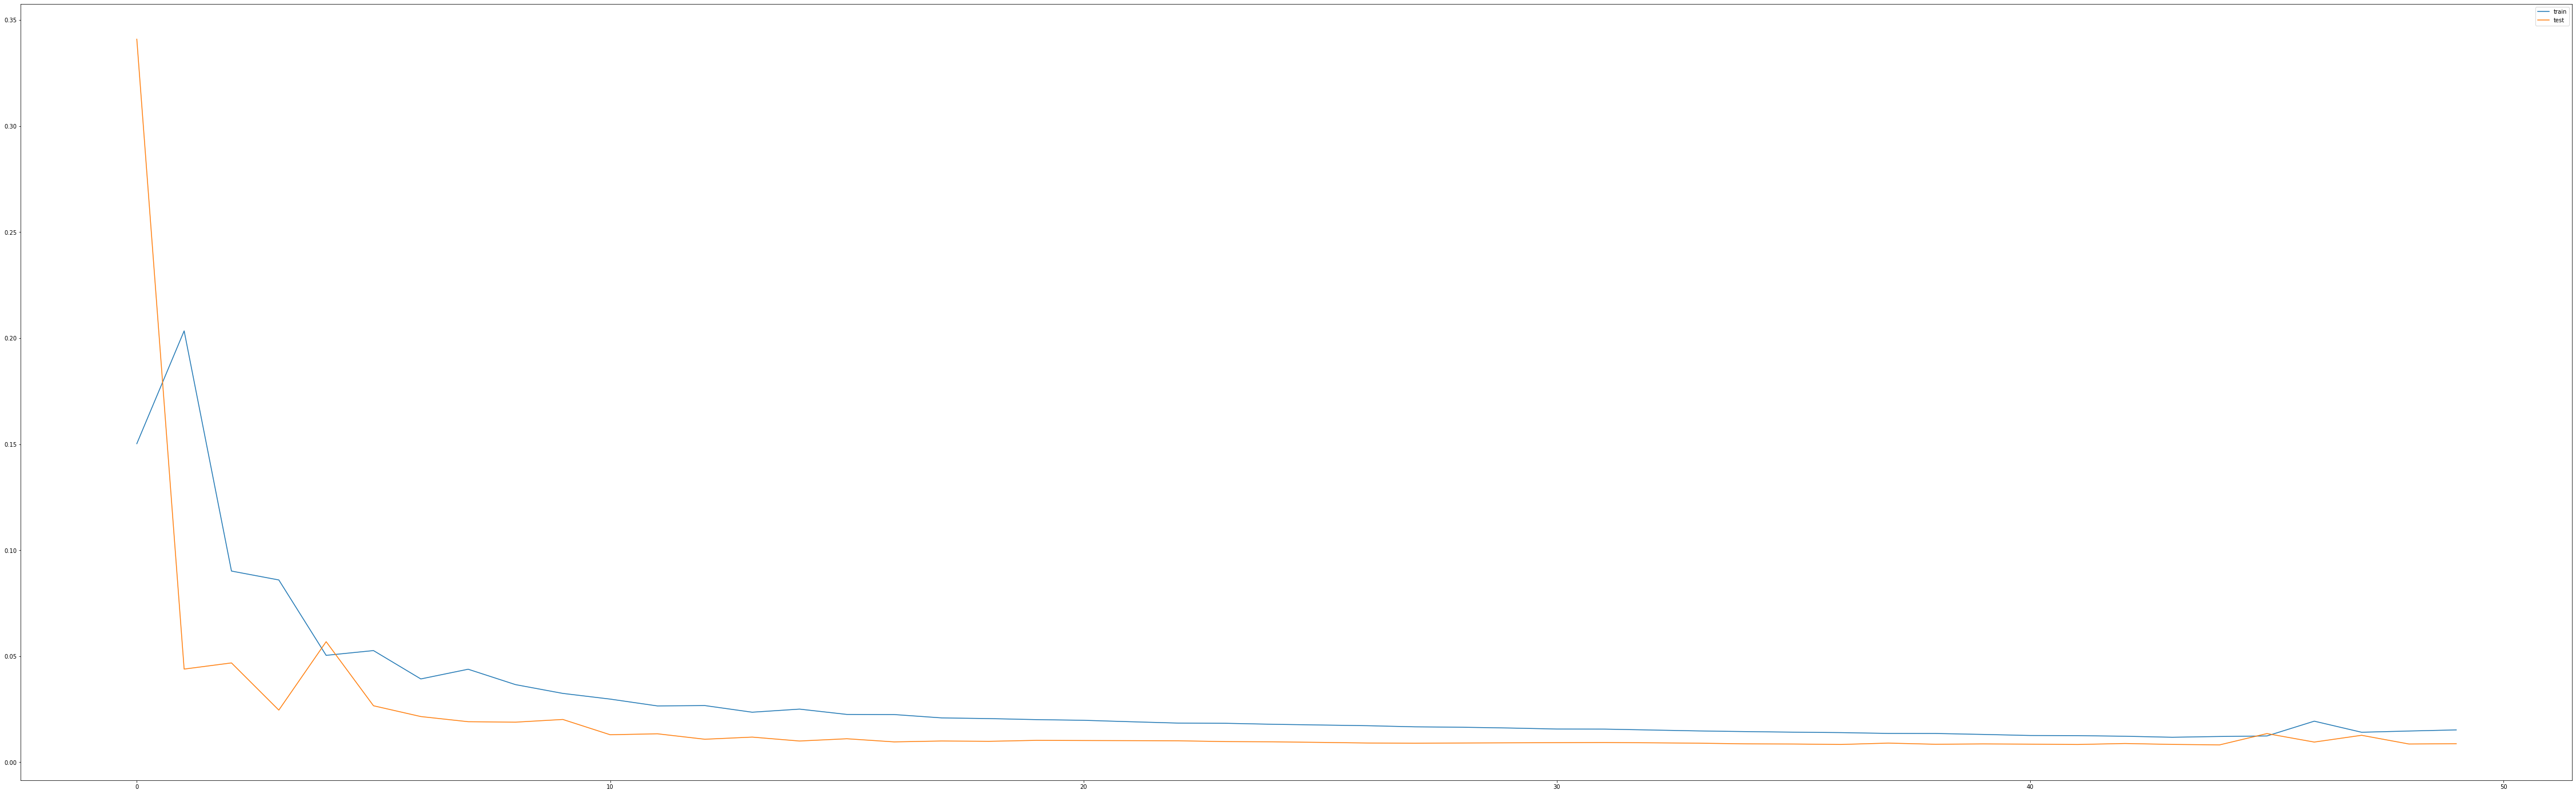

CPU times: user 30min 5s, sys: 11min 29s, total: 41min 34s
Wall time: 8min 56s


In [22]:
%%time
# design network
model_dnn_sort = Sequential()
model_dnn_sort.add(Dense(2048, activation='relu'))
model_dnn_sort.add(Dropout(0.1))
model_dnn_sort.add(Dense(1024, activation='relu'))
model_dnn_sort.add(Dropout(0.1))
model_dnn_sort.add(Dense(512, activation='relu'))
model_dnn_sort.add(Dropout(0.1))
model_dnn_sort.add(Dense(256, activation='relu'))
model_dnn_sort.add(Dropout(0.1))
model_dnn_sort.add(Dense(128, activation='relu'))
model_dnn_sort.add(Dropout(0.1))
model_dnn_sort.add(Dense(100, activation='relu'))
model_dnn_sort.add(Dropout(0.1))
model_dnn_sort.add(Dense(50, activation='relu'))
model_dnn_sort.add(Dropout(0.1))
model_dnn_sort.add(Dense(25, activation='relu'))
model_dnn_sort.add(Dropout(0.1))
model_dnn_sort.add(Dense(1, activation='relu'))
model_dnn_sort.compile(loss='mse', optimizer='adam')
# fit network
history = model_dnn_sort.fit(X_train, y_train, epochs=50, batch_size=30000, validation_split=0.2, verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Finally we plot the results and the metrics:

Para los resultados de las últimas 4 semanas se obtiene un RMSE de  18.864706 , un R2 de  0.6977695451887873  y un MAPE de 25.859156250953674


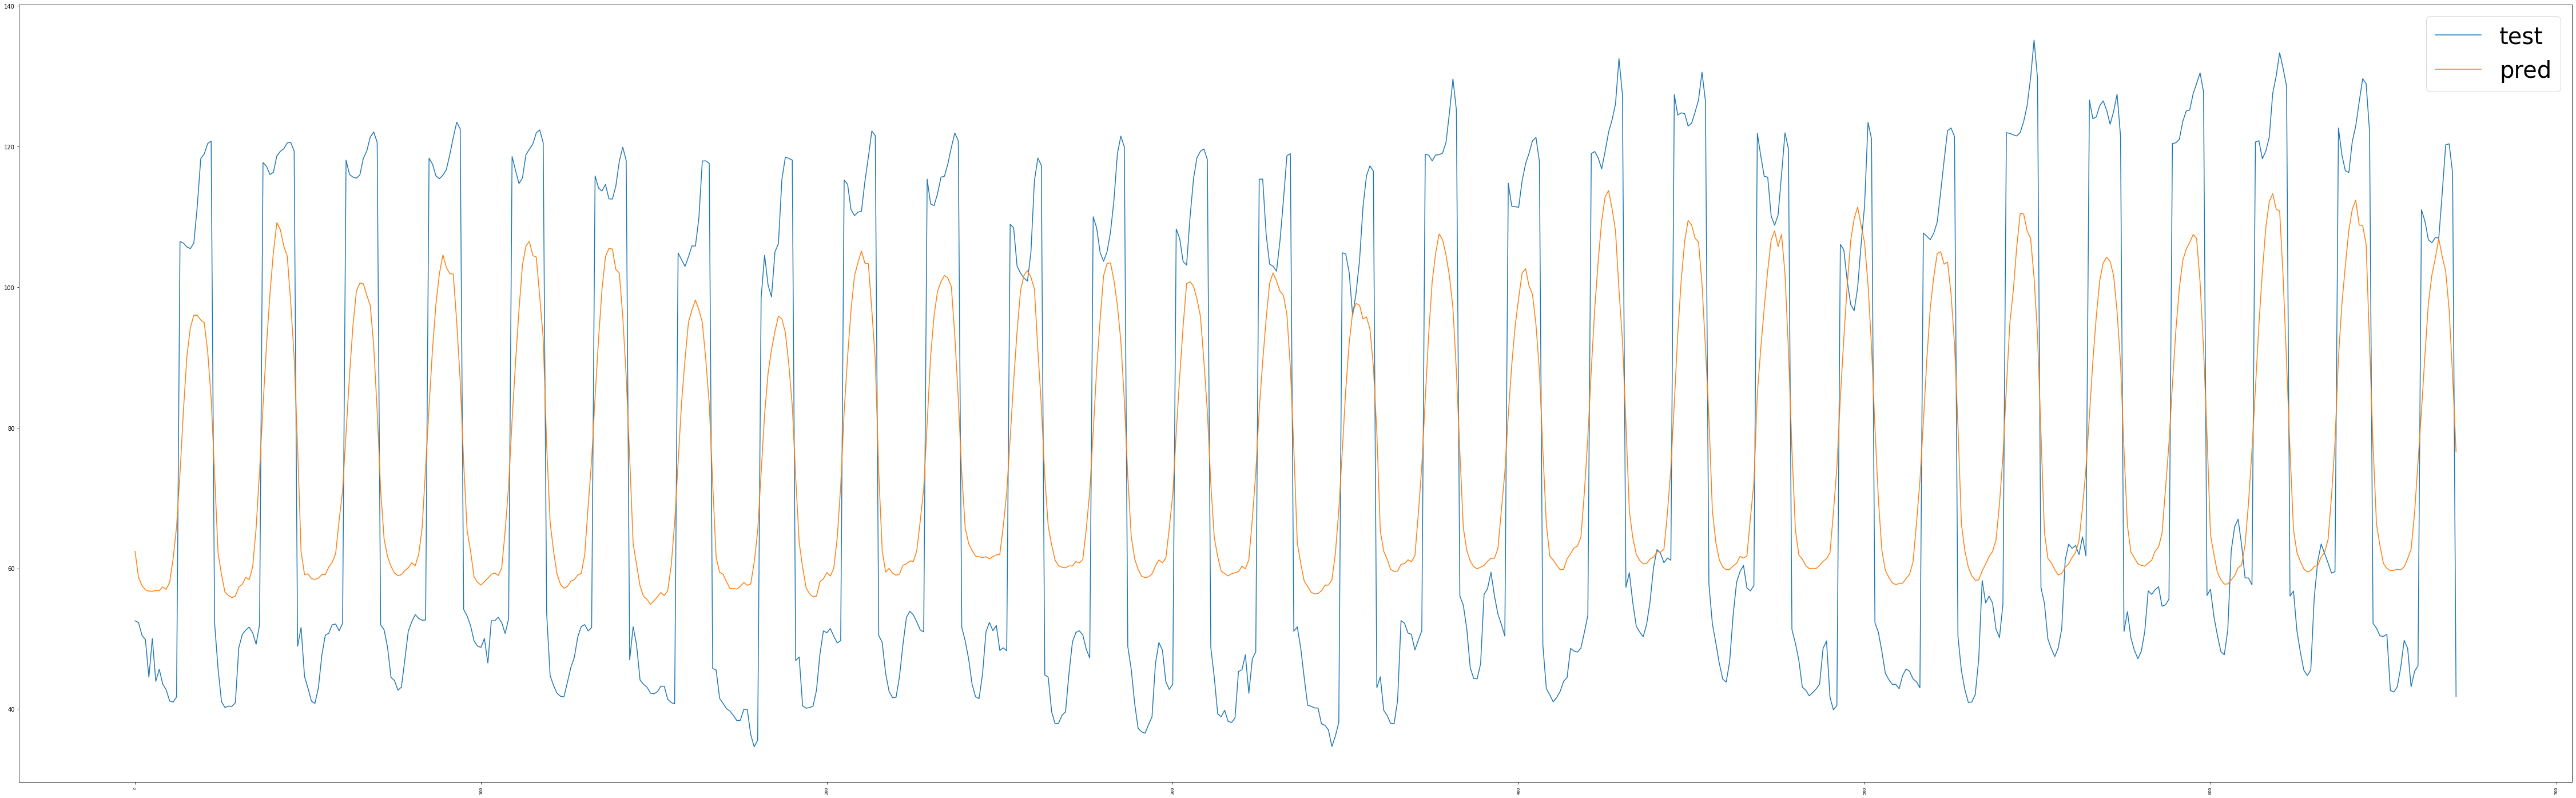

In [23]:
# make a prediction
yhat = model_dnn_sort.predict(X_test)
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, X_test[:, :]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
inv_y = np.concatenate((y_test.reshape(-1,1), X_test[:, :]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate metrics and plot:
plt.rcParams['figure.figsize'] = [80, 25]
print('Para los resultados de las últimas 4 semanas se obtiene un RMSE de ',np.sqrt(mean_squared_error(inv_y, inv_yhat)),', un R2 de ',r2_score(inv_y, inv_yhat),' y un MAPE de',mean_absolute_percentage_error(inv_y, inv_yhat))
plt.plot(inv_y, label='test')
plt.plot(inv_yhat, label='pred')
plt.legend(prop={'size': 40})
plt.xticks(rotation=90, fontsize = 7)
plt.show()

Exporting the results:

In [24]:
pd.DataFrame({'test':inv_y, 'prediccion':inv_yhat},index = y[last_value:].index).to_csv('./../Visualization/Neural_network_DNN_sorted.csv')